# Constructing and testing quant factors                                                 

Concepts

## Fama-French, HML                                                                                           
                                                                                                             
## weekly reversal strategy, quant quake
## return predicting signals, alpha, information ratio
                                                                                                             
References:                                                                                                  
                                                                                                             
- https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html                                    
- Khandani and Lo (2008), “What Happened to the Quants in August 2007?"
   
- Jeremiah Green, John Hand and Frank Zhang (December 2017), "Characteristics that Provide Independent Information about Average U.S. Monthly Stock Returns”, Review of Financial Studies 30:12, 4389-4436


In [3]:
import dives
import time
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

from dives.util import fractiles, DataFrame
from dives.dbengines import SQL, Redis
from dives.structured import BusDates, Benchmarks, CRSP, PSTAT, IBES, Signals
from dives.evaluate import BackTest, run_backtest

import secret    # passwords etc                                                                             
sql = SQL(**secret.value('sql'))
rdb = Redis(**secret.value('redis'))
bd = BusDates(sql)
bench = Benchmarks(sql, bd)
backtest = BackTest(sql, bench, 'RF')
crsp = CRSP(sql, bd, rdb)
pstat = PSTAT(sql, bd)
ibes = IBES(sql, bd)
signals = Signals(sql)
outdir = secret.value('rps')['dir']
html = 'index.html'


### Weekly reversal strategy

In [3]:
    crsp.rdb = None      # do not use redis cache                                                            
    tic = time.time()
    holdings = {}                                                             
    rebalbeg, rebalend = 20060701, 20080831
    for weeknum in bd.week_range(rebalbeg, rebalend):
        pordate = bd.week_end(weeknum)              # rebalance date                                         
        beg = bd.shift(bd.week_beg(weeknum), -1)    # date prior to period for measuring past return         
        start = bd.week_beg(weeknum)                # first day of period to measure past return             
        end = bd.week_beg(weeknum)                  # last day of period to measure past return              

        df = crsp.get_universe(pordate)             # generate new universe every week: common domestic      
        df['beg'] = crsp.get_section('daily', ['prc'], 'date', beg).reindex(df.index)
        df['end'] = crsp.get_section('daily', ['prc'], 'date', end).reindex(df.index)
        df['signal'] = crsp.get_ret(start, end).reindex(df.index)
        df = df[df['beg'].notnull() & df['end'].notnull() & df['signal'].notnull()]
        df['fractile'] = fractiles(df['signal'], [30,70], df['signal'][df.nyse])
        permnos, weights = [],[]
        subs = [(df.fractile == 3) & (df.deciles > 5),               # big winner subportfolio               
                (df.fractile == 3) & (df.deciles <= 5),              # small winner subportfolio             
                (df.fractile == 1) & (df.deciles > 5),               # big loser subportfolio                
                (df.fractile == 1) & (df.deciles <= 5)]              # small loser subportfolio              
        for sub, weight in zip(subs, [-0.5, -0.5, 0.5, 0.5]):        # combine subportfolios for reversal    
            weights += list(weight * df.loc[sub,'cap'] / df.loc[sub,'cap'].sum())
            permnos += list(df.index[sub])
        holdings[pordate] = DataFrame(data=weights, index=permnos, columns=['weights'])
    print('{} unique dates'.format(len(holdings)))


114 unique dates


### Evaluate around quant quake

                            OLS Regression Results                            
Dep. Variable:        weekly reversal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.467
Date:                Fri, 31 Jan 2020   Prob (F-statistic):              0.228
Time:                        12:38:59   Log-Likelihood:                 341.52
No. Observations:                 113   AIC:                            -679.0
Df Residuals:                     111   BIC:                            -673.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha         -0.0004      0.001     -0.358      0.7

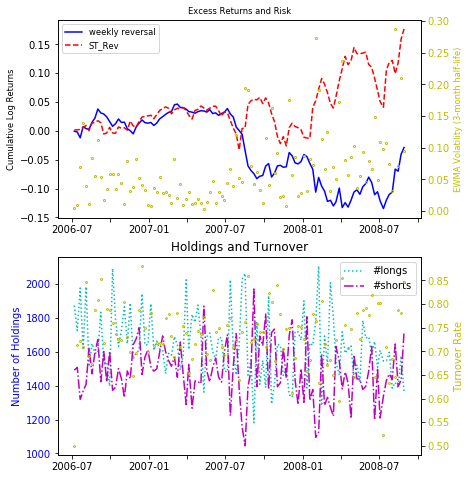

In [4]:
    benchnames = ['ST_Rev']
    backtest.performance(crsp, holdings, label=('weekly reversal'))
    print(backtest.attribution(benchnames, flip=False))
    backtest.plot(benchnames)
    pprint(backtest.annualized)

### Generate HML signal
- allow 6 months after fiscal end for data to become available for portfolio rebalances
- december fiscal year ends and price (for market cap)

In [35]:
    crsp.rdb = rdb   # reaffirm use redis cache                                                              
    rebalbeg, rebalend = 19500601, 20190630
    beg, end = crsp.dates.begmo(rebalbeg, -6), crsp.dates.endmo(rebalend, -6)

    # retrieve required fields from database                                                                 
    df = pstat.get_linked(table = 'annual', date_field = 'datadate',
                          fields = ['ceq','pstk'],  # 'pstkrv', 'pstkl',                                     
                          where = ("ceq > 0 and datadate >= {beg} and datadate <= {end}" \
                                   "".format(beg=beg, end=end)))
    # construct book values                                                                                  
    df['hml'] = 0
    df.loc[df['pstk'].gt(0),   'hml'] = -df.loc[df['pstk'].gt(0),   'pstk']
#    df.loc[df['pstkl'].gt(0),  'hml'] = -df.loc[df['pstkl'].gt(0),  'pstkl']                                
#    df.loc[df['pstkrv'].gt(0), 'hml'] = -df.loc[df['pstkrv'].gt(0), 'pstkrv']                               
    df['hml'] += df['ceq']
    df['rebaldate'] = 0

    # construct b/m ratio                                                                                    
    for datadate in sorted(df['datadate'].unique()):
        f = df['datadate'].eq(datadate)
        rebaldate = crsp.dates.endmo(datadate, 6)        # rebalance date >= 6 months after fiscal end       
        pricedate = bd._months.loc[((rebaldate-10000)//10000, 12), 'endmo']      # december market cap       
        permnos = list(df.loc[f, 'permno'])
        df.loc[f, 'rebaldate'] = rebaldate
        df.loc[f, 'cap'] = (crsp.get_cap(pricedate).reindex(permnos)).values
    df['hml'] /= df['cap']
    print('{} dates {}-{}: {} records'.format(
        len(df['rebaldate'].unique()), min(df['rebaldate']), max(df['rebaldate']), len(df)))


684 dates 19600630-20190628: 259131 records


### Compare to French data library -- highly correlated but some differences remain
Note: in all backtest attribution output, welch test is for different of mean returns before and after 2002.

(portfolio_sorts)  False
                            OLS Regression Results                            
Dep. Variable:                    hml   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     1164.
Date:                Fri, 31 Jan 2020   Prob (F-statistic):          1.30e-149
Time:                        13:04:39   Log-Likelihood:                 1835.9
No. Observations:                 684   AIC:                            -3668.
Df Residuals:                     682   BIC:                            -3659.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0011      

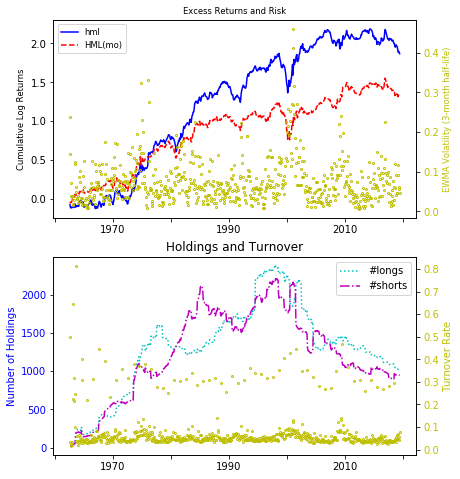

In [36]:
    benchnames = ['HML(mo)']
    signal = 'hml'
    holdings = crsp.portfolio_sorts(signal, data = df, beg = rebalbeg, end = rebalend,
                                    window = 12,     # use latest signal from recent 12 months rebalances    
                                    month = 6)       # determine universe of stocks every June               
    backtest.performance(crsp, holdings, label = signal)
    backtest.attribution(benchnames, flip=False)     # do not flip returns (not a reversal strategy)         
    backtest.plot(benchnames)
    print(backtest.results.summary())
    pprint(backtest.annualized)

### Momentum and Price signals: mom12m, mom1m, mom36m, mom6m, chmom, indmom, divyld

In [4]:
    beg, end = 19270101, 20190630
    tic = time.time()
    intervals = {'mom12m':  (2,12),     # momentum measured over different past periods                      
                 'mom36m': (13,36),
                 'mom6m' :  (2,6),
                 'mom1m' :  (1,1)}

    for signal, past in intervals.items():
        out = DataFrame()
        for pordate in bd.endmo_range(bd.endmo(beg, past[1]), end):  # loop over each rebalance month       
            start = bd.endmo(pordate, -past[1])           # require that  prices available at each point     
            beg1 = bd.shift(start, 1)
            end1 = bd.endmo(pordate, 1-past[0])
            df = crsp.get_section('daily', ['prc'], 'date', start)
            df['end1'] = crsp.get_section('daily', ['prc'], 'date', end1).reindex(df.index)
            df[signal] = crsp.get_ret(beg1, end1).reindex(df.index)   # compute momentum from past returns   
            df['permno'] = df.index
            df['rebaldate'] = pordate
            df = df.loc[df['prc'].notnull() & df['end1'].notnull()]
            out = out.append(df[['rebaldate', 'permno', signal]], ignore_index=True)    # append rows        
        n = signals.save(out, signal, append=False)

    columns = ['chmom', 'divyld','indmom']
    out = DataFrame()
    for pordate in bd.endmo_range(bd.endmo(beg, 12), end):
        start = bd.endmo(pordate, -12)     # require that prices available at each point                     
        beg1 = bd.shift(start, 1)
        end1 = bd.endmo(pordate, -6)
        beg2 = bd.shift(end1, 1)
        end2 = bd.endmo(pordate)
        df = crsp.get_section('daily', ['prc'], 'date', start)
        df['end1'] = crsp.get_section('daily', ['prc'], 'date', end1).reindex(df.index)
        df['end2'] = crsp.get_section('daily', ['prc'], 'date', end2).reindex(df.index)
        df['shrout'] = crsp.get_section('daily', ['shrout'], 'date', end1).reindex(df.index)
        df['mom2'] = crsp.get_ret(beg2, end2).reindex(df.index)
        df['mom1'] = crsp.get_ret(beg1, end1).reindex(df.index)
        df['divyld'] = crsp.get_divamt(beg1, end2).reindex(df.index)  # compute 12-month divyld              
        df['divyld'] /= df['shrout'] * df['end1'].abs()
        df.loc[df['divyld'].isnull(), 'divyld'] = 0                   # if no dividends, divyld is 0         
        df['chmom'] = df['mom1'] - df['mom2']              # compute chmom                                   

        # 6-month two-digit sic industry momentum for stocks with exchcd=1,2,3 shrcd=10,11 siccd>0           
        df = df.join(crsp.get_section('names', ['siccd', 'exchcd', 'shrcd'],  'date', pordate,
                                      start = 0), how='left')
        f = (df['shrcd'].isin([10, 11])       # only include common stocks domiciled in the US               
             & df['exchcd'].isin([1, 2, 3])
             & df['siccd'].gt(0))
        df.loc[f, 'sic2'] = df.loc[f, 'siccd'] // 100
        group = df.groupby(['sic2'])                       # 'indmom' is sic2 group-means of 'mom1'          
        df = df.join(DataFrame(group['mom1'].mean()).rename(columns={'mom1' : 'indmom'}),
                     on='sic2', how='left')

        df['permno'] = df.index
        df['rebaldate'] = pordate
        out = out.append(df.loc[df['prc'].notnull()
                                & df['end1'].notnull()
                                & df['end2'].notnull()
                                & df['shrout'].notnull(),
                                ['rebaldate', 'permno'] + columns],
                         ignore_index=True)
    for signal in columns:   # save signal values to sql                                                     
        n = signals.save(out, signal, append=False)
    print('Elapsed: %.0f secs' % (time.time() - tic))

Elapsed: 3864 secs


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           MINUS mom36m   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     76.18
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.28e-44
Time:                        13:26:55   Log-Likelihood:                 2369.1
No. Observations:                1062   AIC:                            -4730.
Df Residuals:                    1058   BIC:                            -4710.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0017      0.001      1.815      0.070      -0.000       0.003
LT_Rev(mo)     0.8282      0.055     15.055      0.000       0.720       0.936
Mom(mo)       -0.1028      0.052     -1.991      0.047      -0.204      -0.001
Mkt-RF(mo)     0.0139      0.026      0.526      0.599      -0.038       0.066
==============================================================================
Omnibus:                      650.639   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24400.815
Skew:                           2.214   Prob(JB):                         0.00
Kurtosis:                      26.061   Cond. No.                         35.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

### comment

                            OLS Regression Results                            
Dep. Variable:                 mom12m   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                 3.314e+04
Date:                Sat, 01 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:53:40   Log-Likelihood:                 2483.8
No. Observations:                1062   AIC:                            -4960.
Df Residuals:                    1058   BIC:                            -4940.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0013      0.001      1.689      0.0

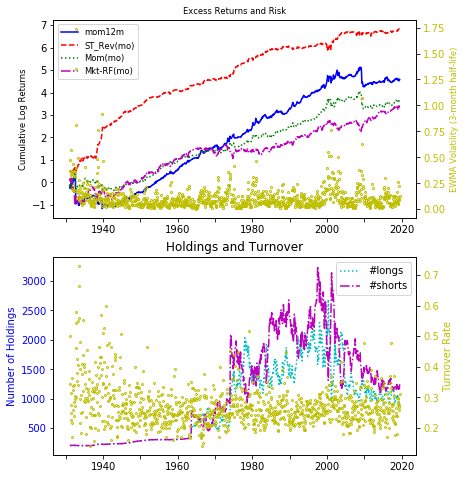

                            OLS Regression Results                            
Dep. Variable:                  mom6m   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     98.94
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.88e-56
Time:                        13:57:46   Log-Likelihood:                 2154.1
No. Observations:                1062   AIC:                            -4300.
Df Residuals:                    1058   BIC:                            -4280.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha         -0.0002      0.001     -0.158      0.8

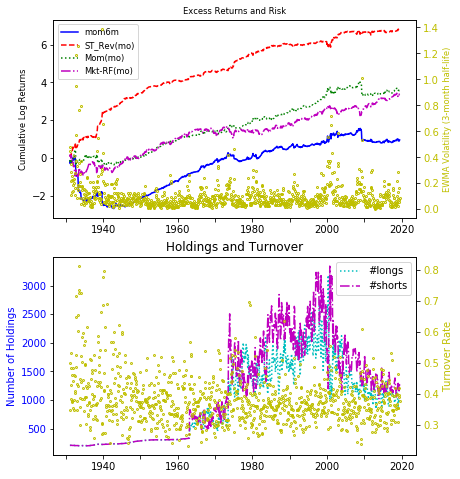

                            OLS Regression Results                            
Dep. Variable:            MINUS mom1m   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                 1.920e+04
Date:                Sat, 01 Feb 2020   Prob (F-statistic):               0.00
Time:                        14:02:00   Log-Likelihood:                 2999.9
No. Observations:                1062   AIC:                            -5992.
Df Residuals:                    1058   BIC:                            -5972.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0009      0.000      1.941      0.0

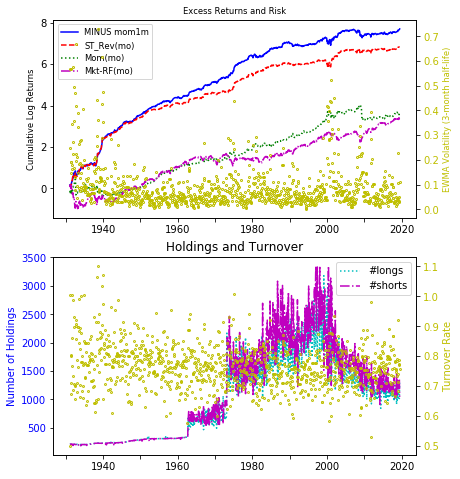

                            OLS Regression Results                            
Dep. Variable:                  chmom   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     17.76
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           2.99e-11
Time:                        14:05:55   Log-Likelihood:                 2200.7
No. Observations:                1062   AIC:                            -4393.
Df Residuals:                    1058   BIC:                            -4374.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0035      0.001      2.904      0.0

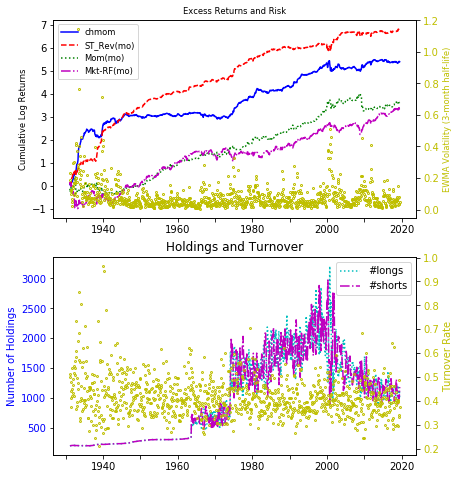

                            OLS Regression Results                            
Dep. Variable:                 indmom   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     46.55
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           2.95e-28
Time:                        14:09:18   Log-Likelihood:                 2332.7
No. Observations:                1062   AIC:                            -4657.
Df Residuals:                    1058   BIC:                            -4638.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0011      0.001      1.071      0.2

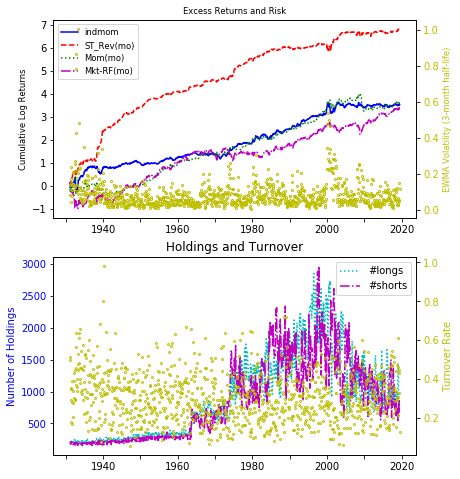

                            OLS Regression Results                            
Dep. Variable:                 divyld   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     67.49
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           2.58e-28
Time:                        14:12:37   Log-Likelihood:                 1927.5
No. Observations:                1062   AIC:                            -3849.
Df Residuals:                    1059   BIC:                            -3834.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0024      0.001      1.795      0.0

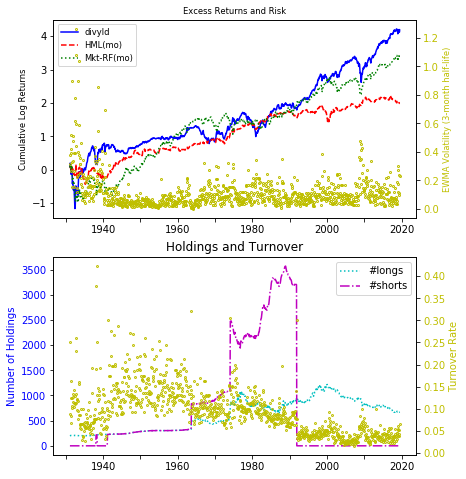

                            OLS Regression Results                            
Dep. Variable:           MINUS mom36m   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     76.18
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.28e-44
Time:                        14:16:03   Log-Likelihood:                 2369.1
No. Observations:                1062   AIC:                            -4730.
Df Residuals:                    1058   BIC:                            -4710.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0017      0.001      1.815      0.0

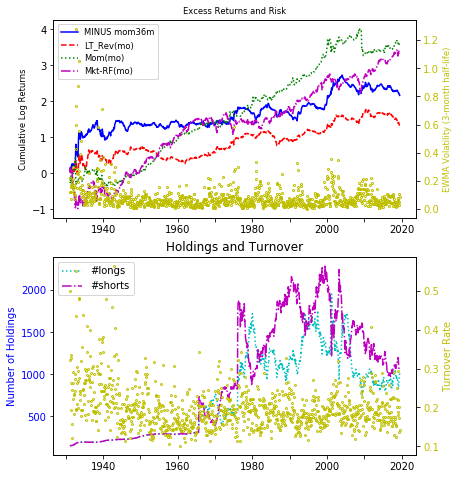

In [6]:
    #%matplotlib agg
    %matplotlib inline
    outdir = ''
    html = ''
    benchnames = ['ST_Rev(mo)','Mom(mo)','Mkt-RF(mo)']    # run backtests and compare to these benchmarks    
    rebalbeg, rebalend = 19301231, 20190630
    for signal in ['mom12m', 'mom6m', 'mom1m', 'chmom','indmom']:
        run_backtest(backtest, crsp, signal, 1,   # only use signal as of current rebalance month
                     benchnames, rebalbeg, rebalend, signals, outdir=outdir, html=html)
        plt.show()
    run_backtest(backtest, crsp, 'divyld', 1,     # only use signal as of current rebalance month
                 ['HML(mo)', 'Mkt-RF(mo)'], rebalbeg, rebalend, signals, outdir=outdir, html=html)
    plt.show()
    run_backtest(backtest, crsp, 'mom36m', 1,     # only use signal as of current rebalance month            
                 ['LT_Rev(mo)','Mom(mo)','Mkt-RF(mo)'],
                 rebalbeg, rebalend, signals, outdir=outdir, html=html)
    plt.show()
    print()

### comment

### comment

### comment

### comment

### comment